In [1]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import zipfile as zf
import cv2
import os

In [2]:
#import zipfile as zf
#files = zf.ZipFile("archive(5).zip", 'r')
#files.extractall('mask')
#files.close()

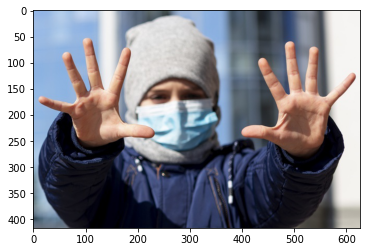

In [3]:
#Sample mask image

os.chdir('/home/jovyan')
plt.imread('mask/mask/Train/Mask/1634.jpg')
import matplotlib.image as mpimg
img = mpimg.imread('mask/mask/Train/Mask/1634.jpg')
imgplot = plt.imshow(img)
plt.imshow(img);

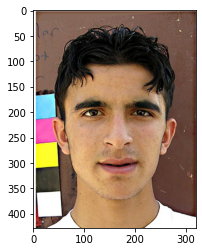

In [4]:
#Sample non-mask image

os.chdir('/home/jovyan')
plt.imread('mask/mask/Train/Non Mask/95.jpg')
img = mpimg.imread('mask/mask/Train/Non Mask/95.jpg')
imgplot = plt.imshow(img)
plt.imshow(img);

In [5]:
#Putting all image names into separate lists for identification and referencing to be used later
import os

os.chdir('/home/jovyan')
os.chdir('mask/mask/Train/Mask/')
trainmask = os.listdir()
os.chdir('/home/jovyan')
os.chdir('mask/mask/Train/Non Mask/')
trainnomask = os.listdir()
os.chdir('/home/jovyan')
os.chdir('mask/mask/Validation/Mask/')
valmask = os.listdir()
os.chdir('/home/jovyan')
os.chdir('mask/mask/Validation/Non Mask/')
valnomask = os.listdir()
os.chdir('/home/jovyan')
os.chdir('mask/mask/Test/Mask/')
testmask = os.listdir()
os.chdir('/home/jovyan')
os.chdir('mask/mask/Test/Non Mask/')
testnomask = os.listdir()

In [6]:
#Initializing matrices and lists

X_train = np.array([])
X_val = np.array([])
X_test = np.array([])
y_train = []
y_val = []
y_test = []
total_train = []
total_val = []
total_test = []

In [7]:
#Function to convert images into matrices, standardize size, and build X matrix

#Image dimension will be size x size
size = 32

def matrix_creator(index_list_mask, index_list_nomask, total_index, X, y, section):
    #k is index of the image number 
    k = 1
    for x in range(len(index_list_mask)):
        
        #Converting image into matrix, referenced by the image name list
        maskimage = mpimg.imread('mask/mask/' + section + '/Mask/' + str(index_list_mask[x]))
        
        #Adding current index to the total index list (to be used later for visualization)
        total_index.append(str(index_list_mask[x]))
        
        #Standardizing size
        maskimage = cv2.resize(maskimage, dsize = (size, size))
        X = np.append(X, maskimage)
        
        #Reshaping matrix into correct dimensions
        X = X.reshape(k, size, size, 3)
        k += 1
        
        #Adding corresponding label for the above image (yes mask)
        y.append(1)

        #Repeating the above code but for no mask image, reading in a no mask image and appending 0 (no mask) to 
        #the y label list
        nomaskimage = mpimg.imread('mask/mask/' + section + '/Non Mask/' + str(index_list_nomask[x]))
        total_index.append(str(index_list_nomask[x]))
        nomaskimage = cv2.resize(nomaskimage, dsize = (size, size))
        X = np.append(X, nomaskimage)
        X = X.reshape(k, size, size, 3)
        k += 1
        y.append(0)
        
    return X, y, total_index

In [8]:
#Running the above function for test, val, and train sections, and standardizing image size from 
#[0, 255] to [-0.5, 0.5] for higher accuracy and to accomodate some transfer learning models
#(for ex. Xception requires images to be standardized to [-0.5, 0.5])

os.chdir('/home/jovyan')
X_test, y_test, total_test = matrix_creator(testmask, testnomask, total_test, X_test, y_test, 'Test')
X_val, y_val, total_val = matrix_creator(valmask, valnomask, total_val, X_val, y_val, 'Validation')
X_train, y_train, total_train = matrix_creator(trainmask, trainnomask, total_train, X_train, y_train, 'Train')
X_train = (X_train / 255) - 0.5
X_val = (X_val / 255) - 0.5
X_test = (X_test / 255) - 0.5

In [9]:
#Shapes of the test, val, train matrices

X_test.shape, X_val.shape, X_train.shape

((100, 32, 32, 3), (306, 32, 32, 3), (600, 32, 32, 3))

In [10]:
#Necessary keras imports

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

2021-10-11 06:13:41.993124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-11 06:13:41.993160: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Base Model

In [11]:
#Creating CNN model

model = Sequential()
model.add(Conv2D(2, 3, input_shape=(size, size, 3)))
model.add(MaxPooling2D(3))
model.add(Dropout(0.1))
model.add(Conv2D(2, 3, input_shape=(size, size, 3)))
model.add(MaxPooling2D(3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 2)         56        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 2)         0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 2)           38        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 2)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1

2021-10-11 06:13:43.883612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-11 06:13:43.883646: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-11 06:13:43.883673: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-pkrhg): /proc/driver/nvidia/version does not exist
2021-10-11 06:13:43.883930: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
#Compiling CNN model

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
#Fitting CNN model, using X_train and y_train for training and X_val and y_val for validation

model.fit(X_train, to_categorical(y_train), epochs = 32,
          validation_data=(X_val, to_categorical(y_val)))

2021-10-11 06:13:44.038511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/32
19/19 [==============================] - 1s 19ms/step - loss: 0.7523 - accuracy: 0.4783 - val_loss: 0.6639 - val_accuracy: 0.6830
Epoch 2/32
19/19 [==============================] - 0s 9ms/step - loss: 0.7235 - accuracy: 0.4433 - val_loss: 0.6645 - val_accuracy: 0.6536
Epoch 3/32
19/19 [==============================] - 0s 9ms/step - loss: 0.7089 - accuracy: 0.4350 - val_loss: 0.6708 - val_accuracy: 0.6569
Epoch 4/32
19/19 [==============================] - 0s 9ms/step - loss: 0.6968 - accuracy: 0.5117 - val_loss: 0.6757 - val_accuracy: 0.6797
Epoch 5/32
19/19 [==============================] - 0s 9ms/step - loss: 0.6849 - accuracy: 0.6083 - val_loss: 0.6654 - val_accuracy: 0.7451
Epoch 6/32
19/19 [==============================] - 0s 9ms/step - loss: 0.6668 - accuracy: 0.7000 - val_loss: 0.6276 - val_accuracy: 0.8072
Epoch 7/32
19/19 [==============================] - 0s 9ms/step - loss: 0.6361 - accuracy: 0.7483 - val_loss: 0.5595 - val_accuracy: 0.8366
Epoch 8/32
19/19 [=

In [14]:
#Model results on test data

result = model.evaluate(X_test, to_categorical(y_test))
print("Test data loss: ", result[0], "Test data accuracy: ", result[1])

4/4 [==============================] - 0s 3ms/step - loss: 0.2149 - accuracy: 0.9500
Test data loss:  0.21489278972148895 Test data accuracy:  0.949999988079071


In [15]:
#Collecting predictions of X_test

X_pred = []
for x in model.predict(X_test):
    X_pred.append(np.argmax(x))

In [16]:
#Calculating accuracy of X_test predictions

np.mean([X_pred[a] == y_test[a] for a in range(len(X_pred))])

0.95

In [17]:
#Splitting predictions into yes mask (pred_mask) and no mask (pred_nomask) predictions

pred_mask = []
pred_nomask = []
for index, x in enumerate(X_pred):
    if x:
        pred_mask.append(index)
    else:
        pred_nomask.append(index)

In [18]:
#Collecting indices (image names) of each image in pred_mask and pred_nomask

index_testmaskpred = [total_test[x] for x in pred_mask]
index_testnomaskpred = [total_test[x] for x in pred_nomask]

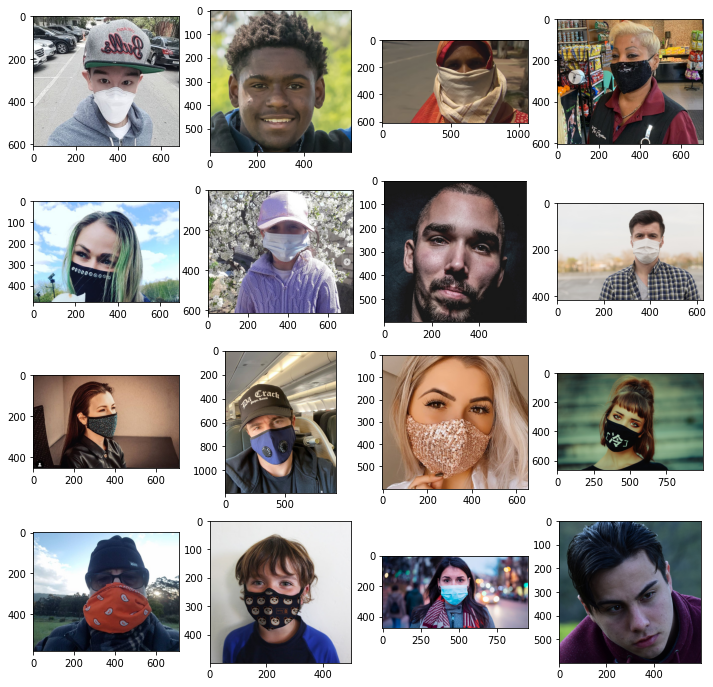

In [19]:
#16 (4x4) yes mask predictions

os.chdir('/home/jovyan')
fig = plt.figure(figsize=(12, 12))
j = 1

import random
random.shuffle(index_testmaskpred)

for x in index_testmaskpred[:16]:
    if x in testmask:
        img = mpimg.imread('mask/mask/Test/Mask/' + x)     #checking whether the image is classified correctly
    else:
        img = mpimg.imread('mask/mask/Test/Non Mask/' + x) #checking whether the image is classified incorrectly
    fig.add_subplot(4, 4, j)                               #creating 4x4 grid
    plt.imshow(img)                                        #adding image in corresponding position
    j += 1
plt.show()

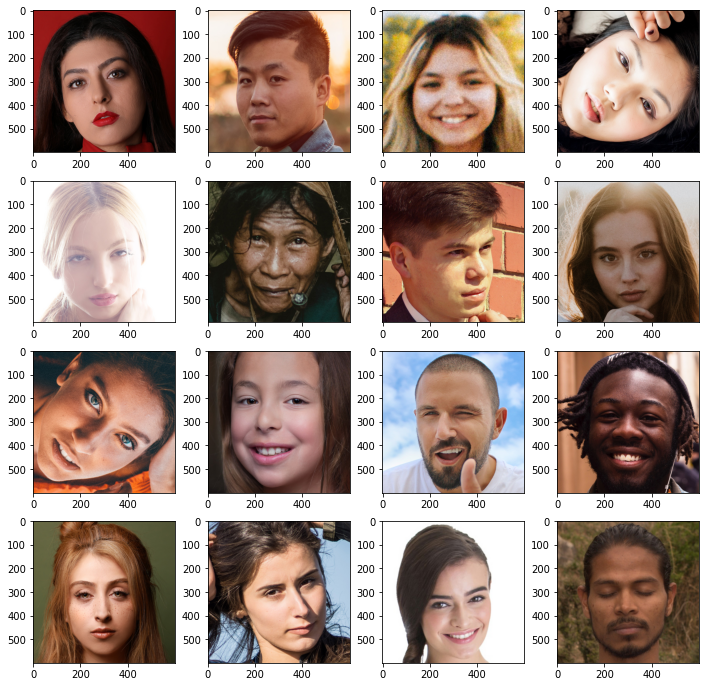

In [20]:
#16 (4x4) no mask predictions

os.chdir('/home/jovyan')
fig = plt.figure(figsize=(12, 12))
j = 1

import random
random.shuffle(index_testnomaskpred)

for x in index_testnomaskpred[:16]:
    if x in testmask:
        img = mpimg.imread('mask/mask/Test/Mask/' + x)     #checking whether the image is classified correctly
    else:
        img = mpimg.imread('mask/mask/Test/Non Mask/' + x) #checking whether the image is classified incorrectly
    fig.add_subplot(4, 4, j)                               #creating 4x4 grid
    plt.imshow(img)                                        #adding image in corresponding position
    j += 1
plt.show()

## 2. Hyperparameter Tuning

In [21]:
#Defining function to create model, to be used in the KerasClassifier wrapper

def scikit_keras(activation = 'sigmoid', optimizer = 'Adam'):
    model = Sequential()
    model.add(Conv2D(2, 3, input_shape=(size, size, 3)))
    model.add(MaxPooling2D(3))
    model.add(Dropout(0.1))
    model.add(Conv2D(2, 3, input_shape=(size, size, 3)))
    model.add(MaxPooling2D(3))
    model.add(Flatten())
    model.add(Dense(2, activation = activation))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
    return model

In [22]:
#Using wrapper to allow scikit-learn methods on the keras model, using above function to create the model

from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn = scikit_keras, batch_size = 24, epochs = 35)

In [23]:
#Performing cv

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
cross_val_score(model, X_train, y_train, cv = KFold(3))

Epoch 1/35
17/17 [==============================] - 1s 5ms/step - loss: 0.6741 - accuracy: 0.5875
Epoch 2/35
17/17 [==============================] - 0s 5ms/step - loss: 0.6562 - accuracy: 0.6350
Epoch 3/35
17/17 [==============================] - 0s 5ms/step - loss: 0.6277 - accuracy: 0.6850
Epoch 4/35
17/17 [==============================] - 0s 5ms/step - loss: 0.6036 - accuracy: 0.7075
Epoch 5/35
17/17 [==============================] - 0s 5ms/step - loss: 0.5777 - accuracy: 0.7450
Epoch 6/35
17/17 [==============================] - 0s 5ms/step - loss: 0.5460 - accuracy: 0.7550
Epoch 7/35
17/17 [==============================] - 0s 5ms/step - loss: 0.5242 - accuracy: 0.7775
Epoch 8/35
17/17 [==============================] - 0s 5ms/step - loss: 0.4945 - accuracy: 0.7850
Epoch 9/35
17/17 [==============================] - 0s 5ms/step - loss: 0.4638 - accuracy: 0.8250
Epoch 10/35
17/17 [==============================] - 0s 5ms/step - loss: 0.4373 - accuracy: 0.8350
Epoch 11/35
17/17 [

array([0.88      , 0.85000002, 0.89499998])

In [24]:
#Parameters for exhaustive gridsearch

activations = ['relu', 'tanh', 'sigmoid', 'softmax']
optimizers = ['SGD', 'RMSprop', 'Adam', 'Adagrad']
epochs = [20, 30, 40]

In [25]:
param_grid = dict(activation = activations, optimizer = optimizers, epochs = epochs)#, batch_size = batch)

In [26]:
#Performing grid search

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid = param_grid, cv=4, scoring="accuracy")
new_fit = grid.fit(X_train, y_train, verbose = 0)
new_fit.best_score_, new_fit.best_params_

(0.8783333333333334,
 {'activation': 'softmax', 'epochs': 40, 'optimizer': 'Adam'})

## 3. Distributed Model

In [27]:
#Creating mirrored strategy

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
strategy = tf.distribute.MirroredStrategy()

In [28]:
#Setting up model and distributed architecture

with strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(size, size, 3)))
    model.add(MaxPooling2D(3))
    model.add(Dropout(0.2))
    model.add(Conv2D(2, 3))
    model.add(MaxPooling2D(3))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(8, activation = 'softmax'))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
#Reformatting into tf.data format
train_data = tf.data.Dataset.from_tensor_slices((X_train, to_categorical(y_train)))
val_data = tf.data.Dataset.from_tensor_slices((X_val, to_categorical(y_val)))
test_data = tf.data.Dataset.from_tensor_slices((X_test, to_categorical(y_test)))

batch = 64
train_data = train_data.batch(batch)
val_data = val_data.batch(batch)
test_data = test_data.batch(batch)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options)
val_data = val_data.with_options(options)
test_data = test_data.with_options(options)

In [29]:
#Model architecture

model.summary()

Model: "sequential_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_394 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_394 (MaxPoolin (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_197 (Dropout)        (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_395 (Conv2D)          (None, 8, 8, 2)           578       
_________________________________________________________________
max_pooling2d_395 (MaxPoolin (None, 2, 2, 2)           0         
_________________________________________________________________
dropout_198 (Dropout)        (None, 2, 2, 2)           0         
_________________________________________________________________
flatten_197 (Flatten)        (None, 8)              

In [30]:
#Fitting model

model.fit(train_data, validation_data = val_data, epochs = 32, verbose = 0)

2021-10-11 06:25:27.665289: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [31]:
#Evaluating the model

result = model.evaluate(test_data)
print("Test data loss: ", result[0], "Test data accuracy: ", result[1])

2/2 [==============================] - 0s 6ms/step - loss: 0.2808 - accuracy: 0.9500
Test data loss:  0.2808000445365906 Test data accuracy:  0.949999988079071


## 4. Transfer Learning

In [32]:
#Function to run transfer model on entire dataset
import tensorflow as tf

def run_transfer_model(name):
    base_model = name
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.05)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.05)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs = base_model.input, outputs = preds)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics='accuracy')
    model.fit(X_train, to_categorical(y_train), epochs = 16,
              validation_data=(X_val, to_categorical(y_val)), verbose = 0)
    testset = model.evaluate(X_test, to_categorical(y_test))
    return 'Test set loss: ', testset[0], 'Test set accuracy: ', testset[1]

In [33]:
run_transfer_model(tf.keras.applications.MobileNet(weights='imagenet', include_top=False))

4/4 [==============================] - 0s 16ms/step - loss: 0.0472 - accuracy: 0.9800


('Test set loss: ',
 0.04723978042602539,
 'Test set accuracy: ',
 0.9800000190734863)

## 5. Distributed Transfer Learning Model

In [34]:
#Same as distributed code from above, but now using a transfer learning model

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    
    base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs = base_model.input, outputs = preds)
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
train_data = tf.data.Dataset.from_tensor_slices((X_train, to_categorical(y_train)))
val_data = tf.data.Dataset.from_tensor_slices((X_val, to_categorical(y_val)))
test_data = tf.data.Dataset.from_tensor_slices((X_test, to_categorical(y_test)))

batch = 64
train_data = train_data.batch(batch)
val_data = val_data.batch(batch)
test_data = test_data.batch(batch)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options)
val_data = val_data.with_options(options)
test_data = test_data.with_options(options)

In [35]:
#Fitting model

model.fit(train_data, validation_data = val_data, epochs = 32, verbose = 0)

2021-10-11 06:26:53.425500: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2021-10-11 06:27:23.821318: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2021-10-11 06:27:54.439418: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2021-10-11 06:28:24.457613: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2021-10-11 06:28:57.747716: W tensorflow/core/framework/dataset.cc:6

In [36]:
#Evaluating the model

result = model.evaluate(test_data)
print("Test data loss: ", result[0], "Test data accuracy: ", result[1])

2/2 [==============================] - 0s 21ms/step - loss: 0.1242 - accuracy: 0.9700
Test data loss:  0.12415587157011032 Test data accuracy:  0.9700000286102295
